## Fitting stars as linear combinations of other stars
### to-do items / bugs:
- Try varying the hyperparameters: 
    - variance of spectra
    - variance of continuum
    - K
    - start_k
- Patch rather than throw away missing data
- Look at all good Tc lines

In [39]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with h5py.File('../data/block_o_spectra.hdf5') as f:
    fluxs = np.copy(f['fluxs'])
    waves = np.copy(f['waves'])
    star_names = np.copy(f['star_name'])
    
N = len(star_names)

One example of a potential Tc line:

(0.8, 1.0)

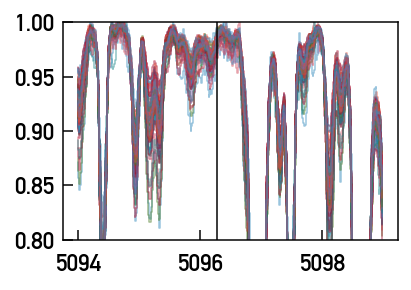

In [4]:
Tc_line = 5096.280
Ha_line = 6562.8
inds = (waves > 5094.) & (waves < 5099.)
for i in range(N):
    plt.step(waves[inds], fluxs[i,inds], alpha=0.5)
plt.axvline(Tc_line, color='k')
plt.ylim([0.8,1.0])

In [5]:
# Hackety fucking hack
tiny = 0.001 # magic
mask = fluxs > tiny
keep = np.sum(mask, axis=0) == N # OMG this is HARSH
# The line above saves us from having to repair the missing data.
# Hogg knows how to do that.

In [6]:
# trim data
waves = waves[keep]
fluxs = fluxs[:, keep]
mask = mask[:, keep]

In [31]:
def make_B(waves, start_order = 2, stop_order = 20):
    thetas = np.pi * (waves - waves.min())/(waves.max() - waves.min())
    K = stop_order - start_order
    B = np.zeros((2 * K, len(thetas)))
    for k in range(K):
        B[2*k] = np.cos(k * thetas)
        B[2*k+1] = np.sin(k * thetas)
    return B
    

def fit_one_spectrum(thisn, hypers = (0.1, 1.e6)):
    """
    bugs:
    -----
    - Depends on global variables.
    - Repeating code.
    """
    otherns = np.delete(np.arange(N), thisn)
    A = fluxs[otherns, :]
    B = make_B(waves)
    K,M = np.shape(B)
    A = np.append(A, B, axis=0)
    ATA = np.dot(A, A.T)
    ATy = np.dot(A, fluxs[thisn])
    lambdainv_diag = np.repeat(hypers[0] * (N * N), N-1) # inverse variance
    lambdainv_diag = np.append(lambdainv_diag, np.repeat(hypers[1], K))
    lambdainv = np.diag(lambdainv_diag)
    # regularized least-square fit
    x = np.linalg.solve(ATA + lambdainv, ATy)
    y_predicted = np.dot(A.T, x)
    return y_predicted

In [32]:
ys_predicted = np.zeros_like(fluxs)
for n in range(N):
    ys_predicted[n] = fit_one_spectrum(n)

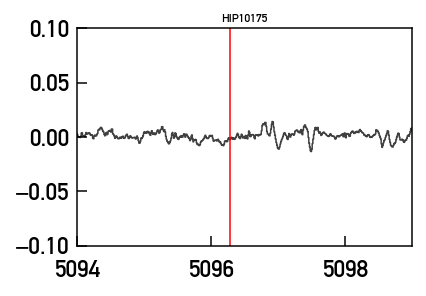

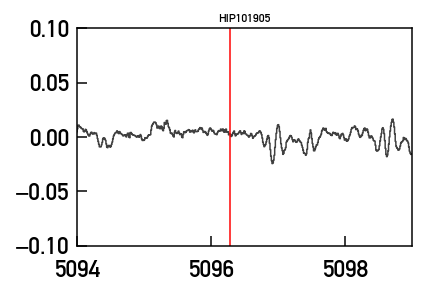

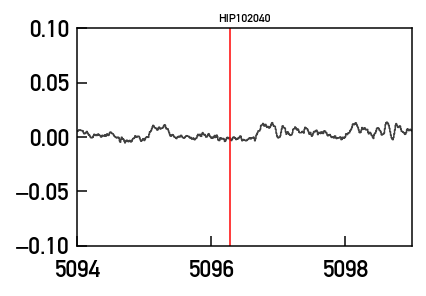

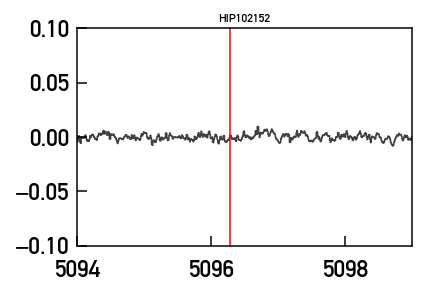

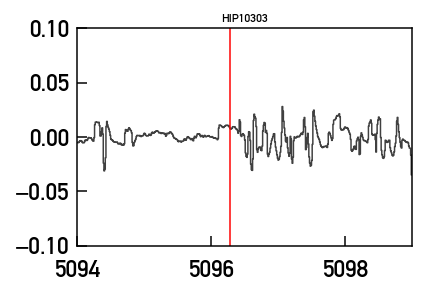

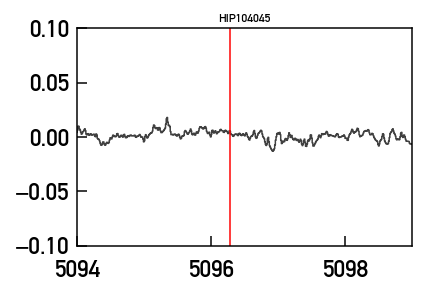

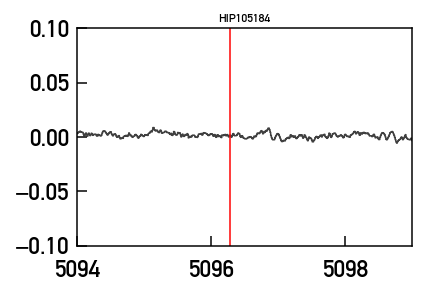

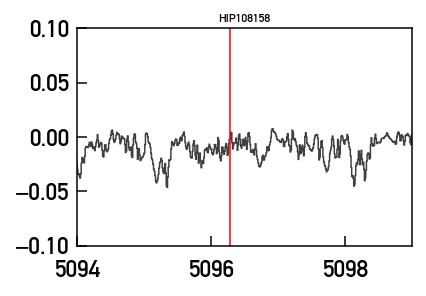

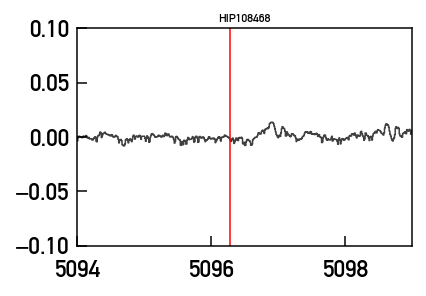

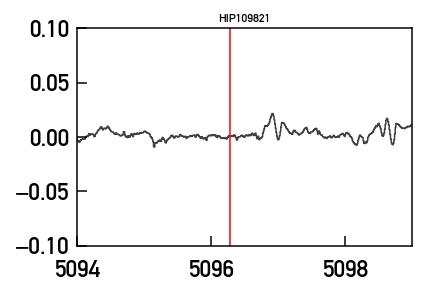

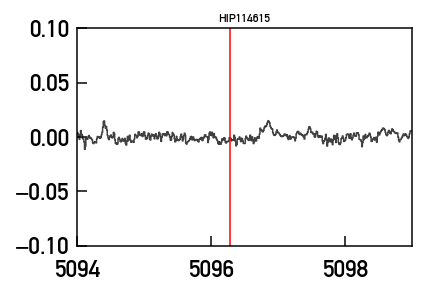

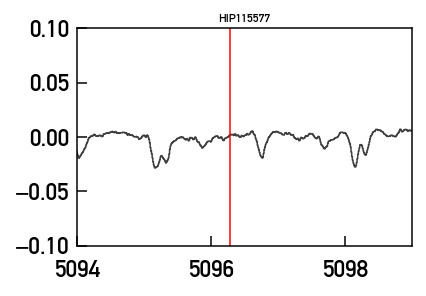

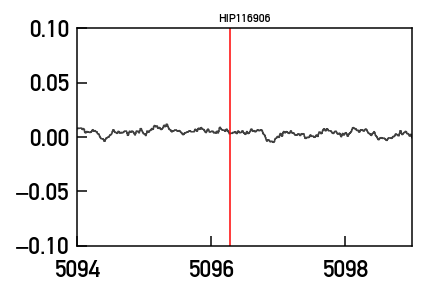

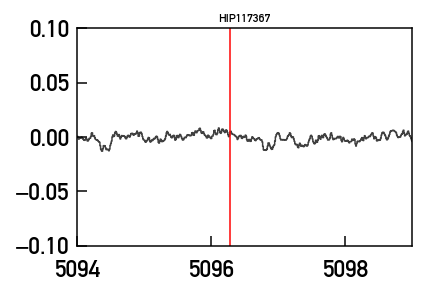

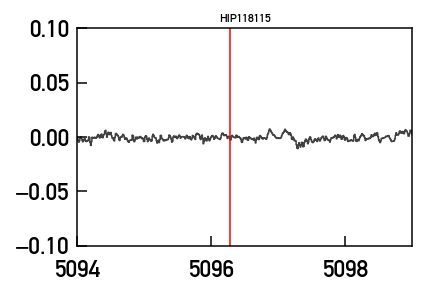

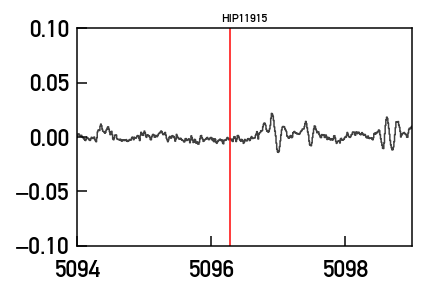

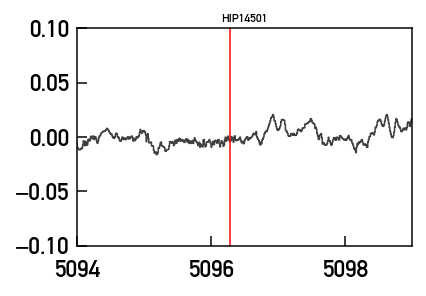

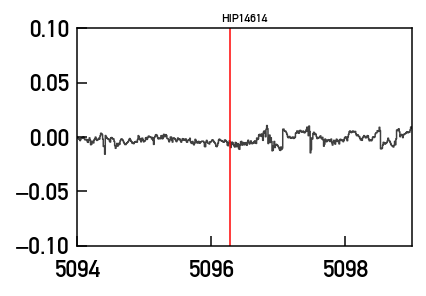

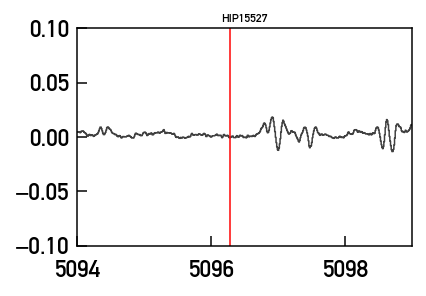

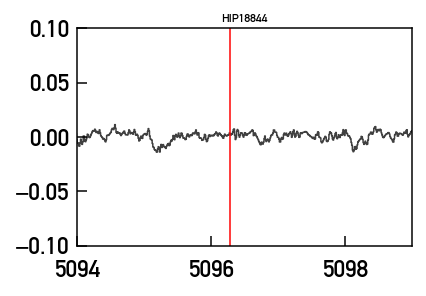

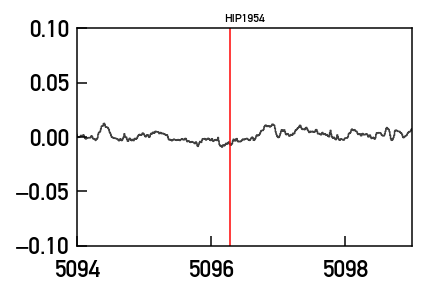

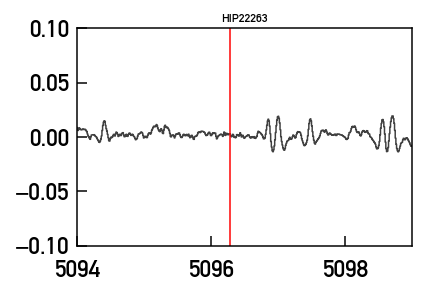

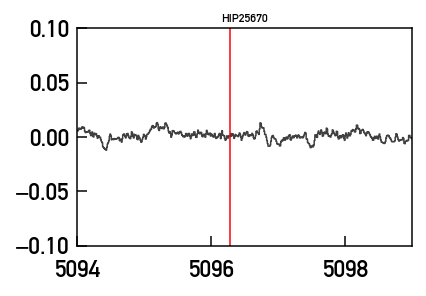

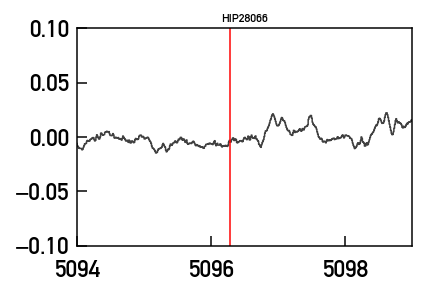

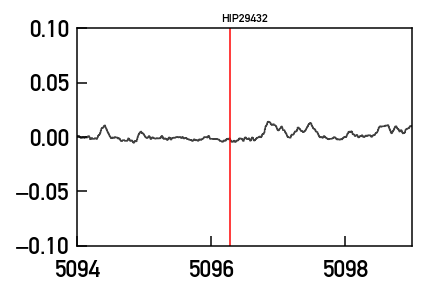

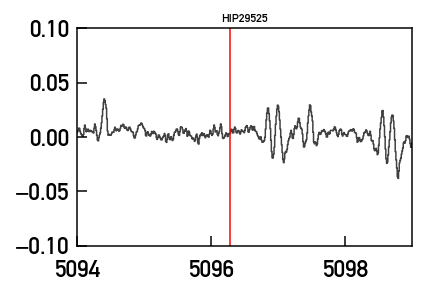

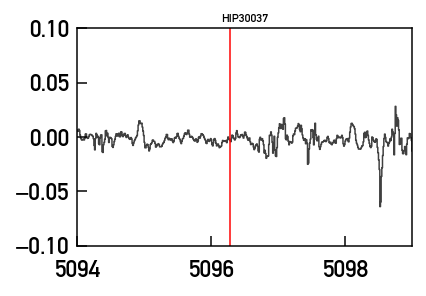

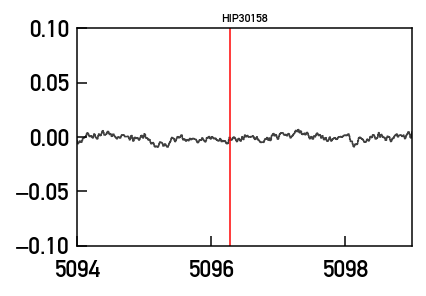

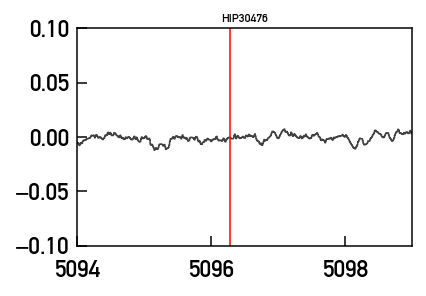

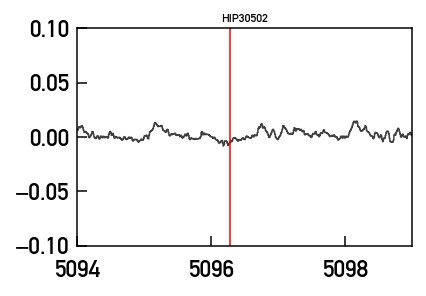

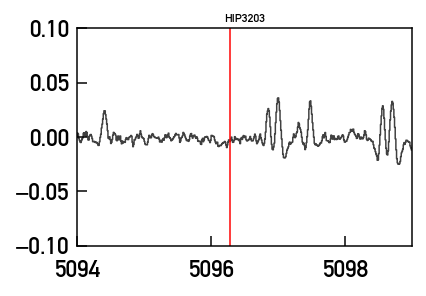

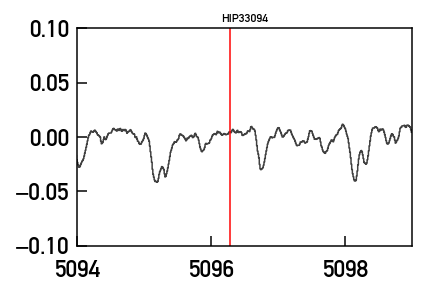

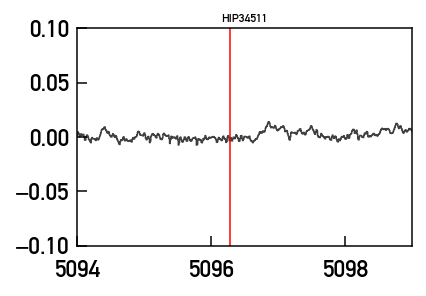

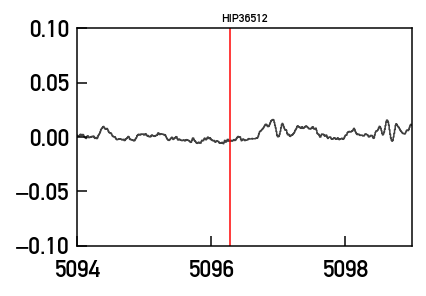

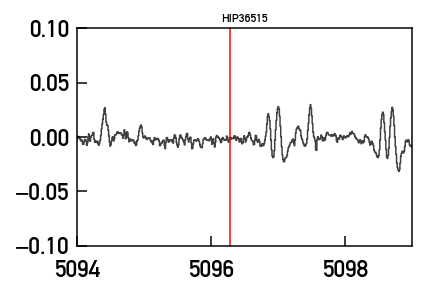

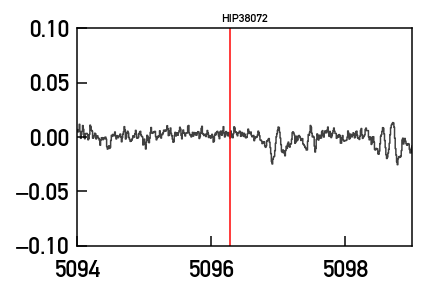

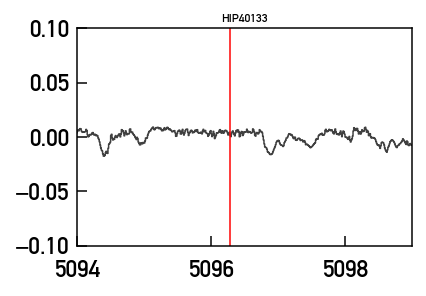

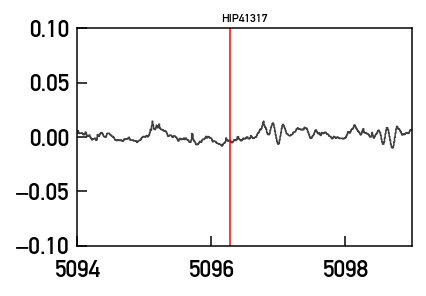

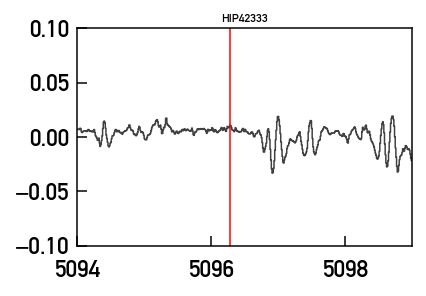

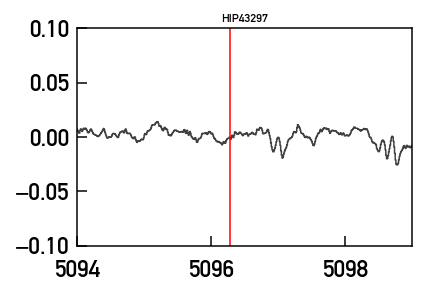

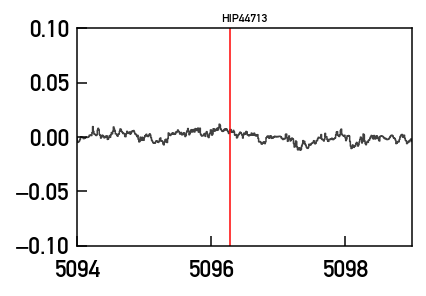

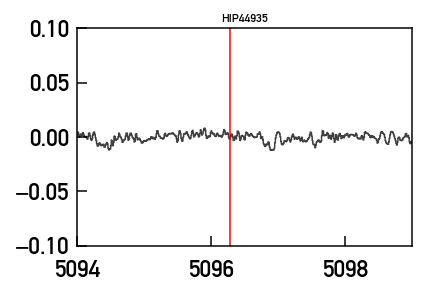

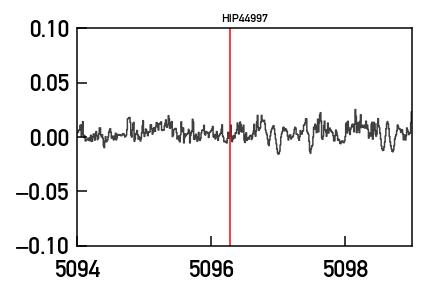

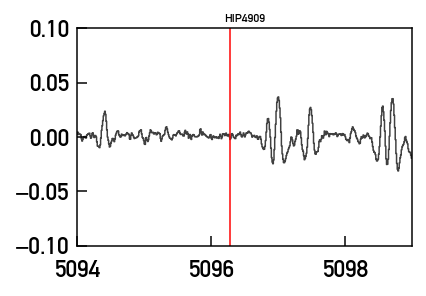

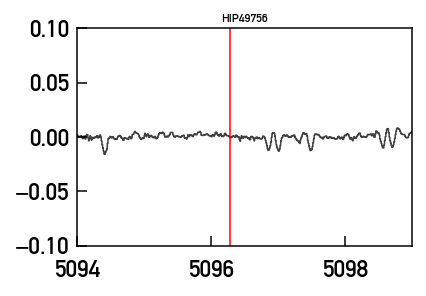

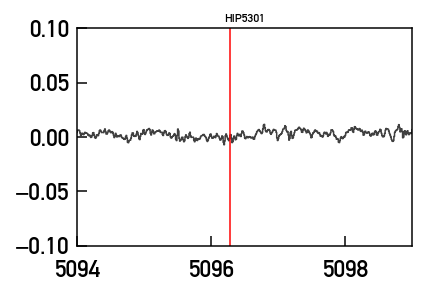

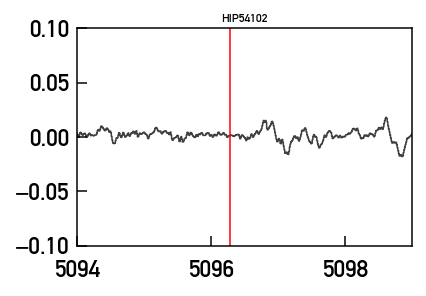

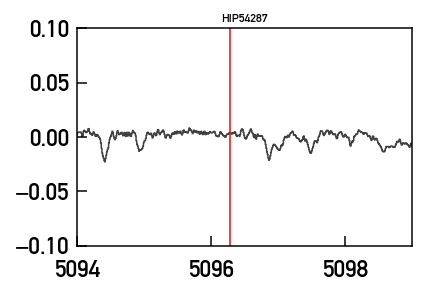

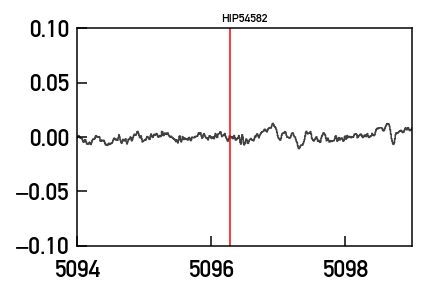

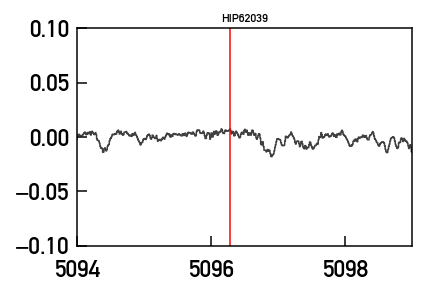

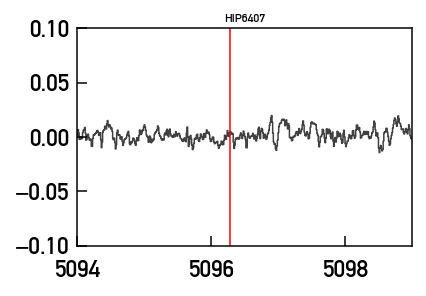

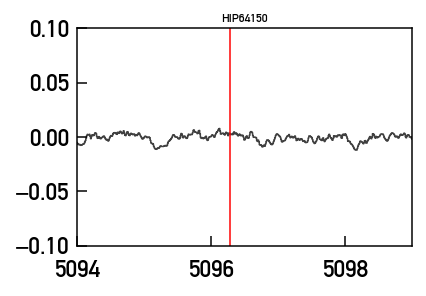

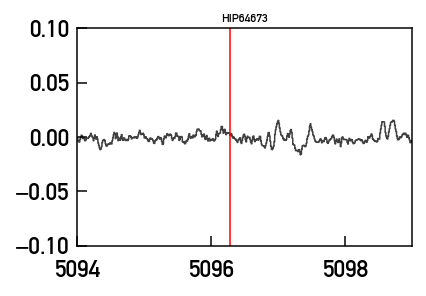

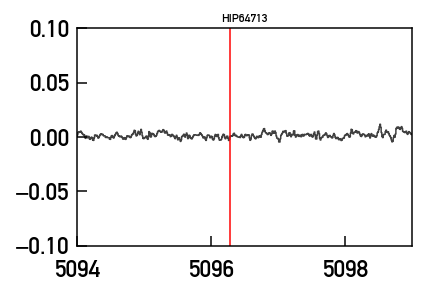

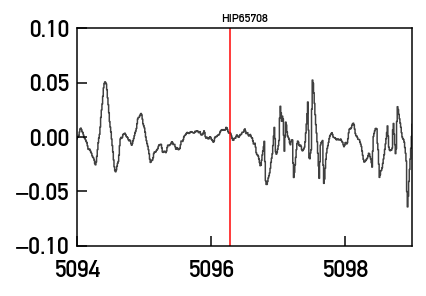

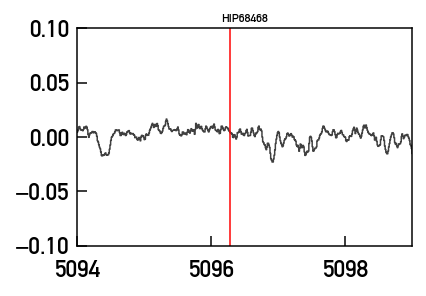

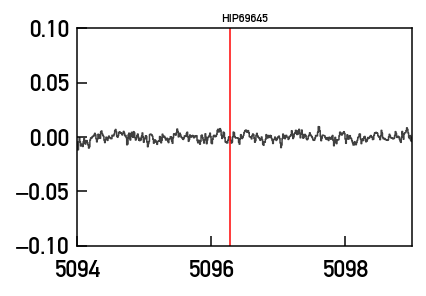

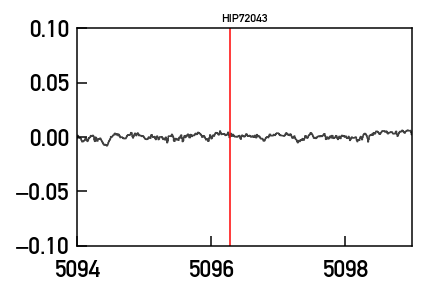

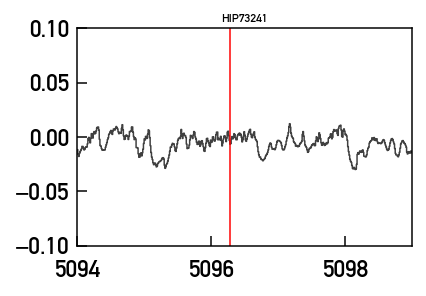

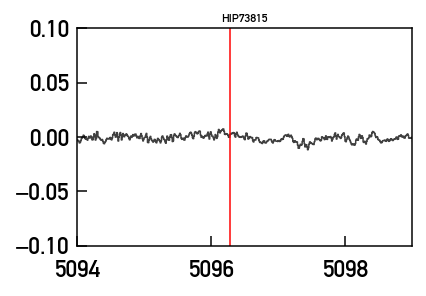

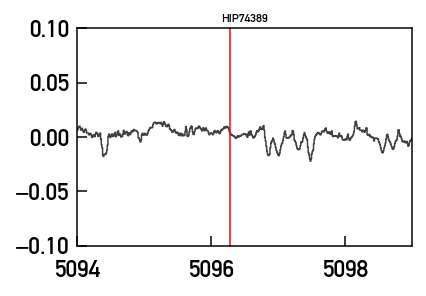

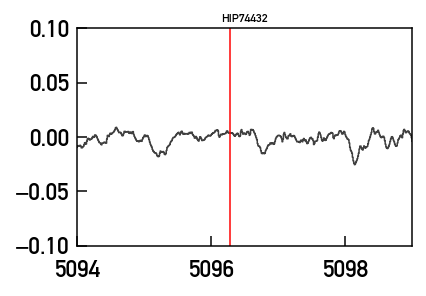

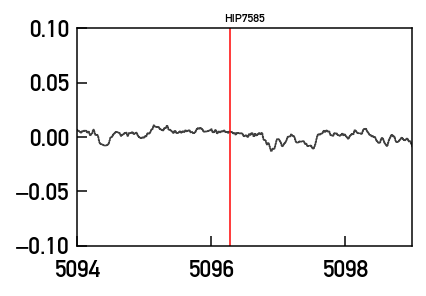

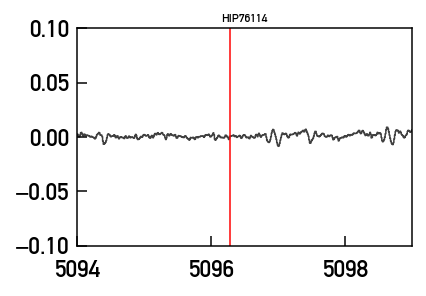

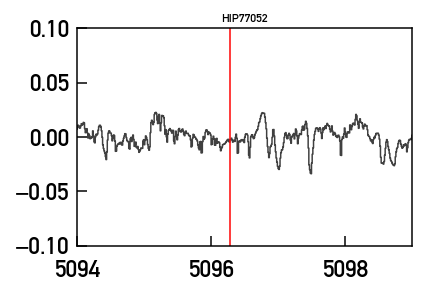

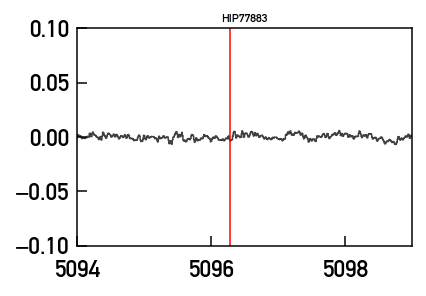

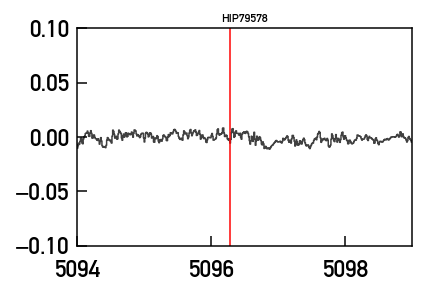

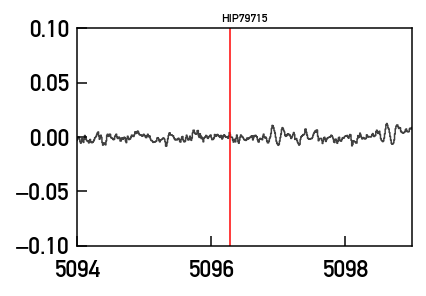

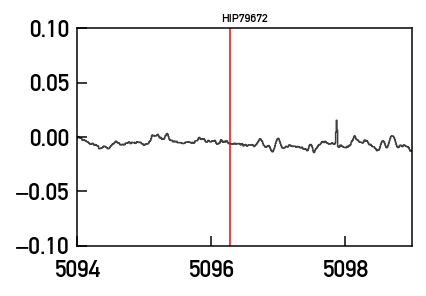

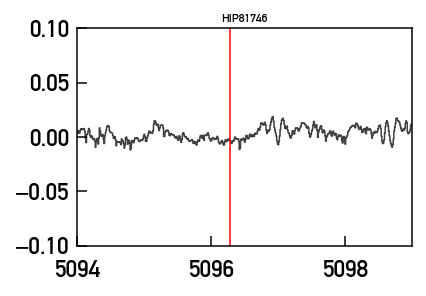

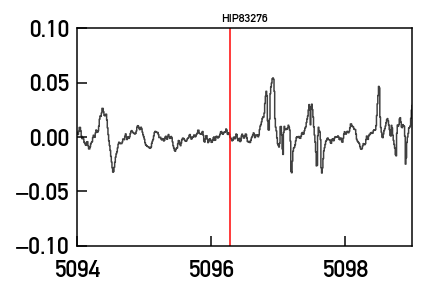

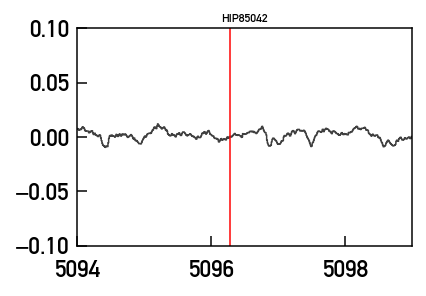

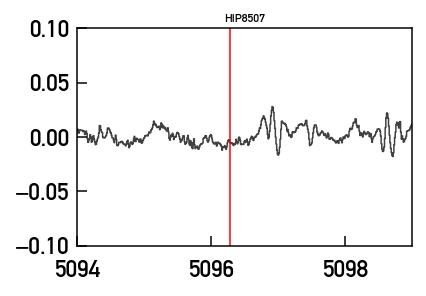

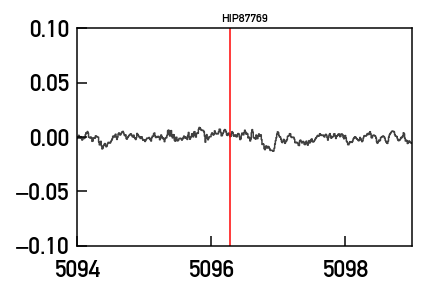

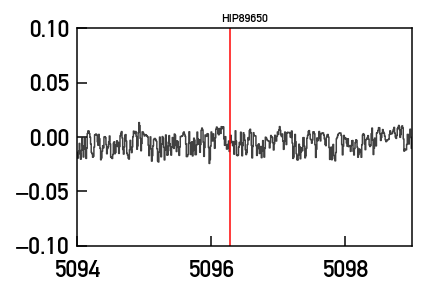

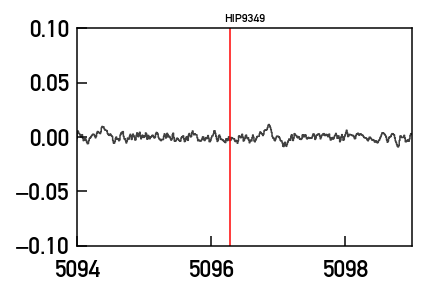

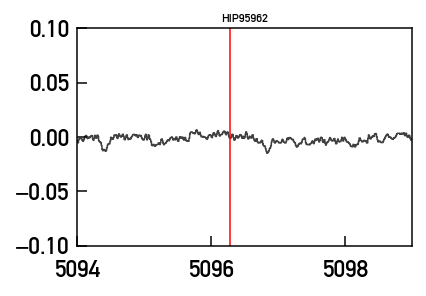

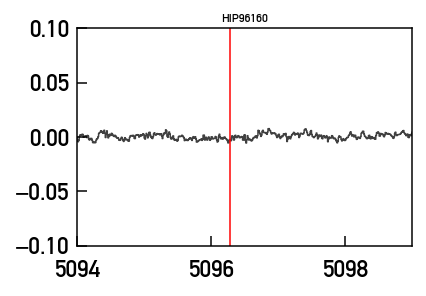

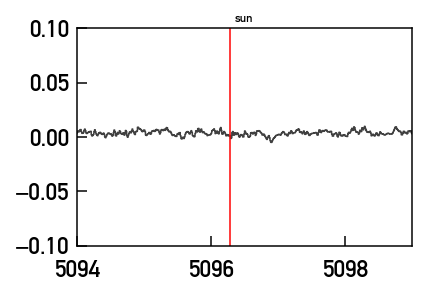

In [42]:
xlim = (5094, 5099)
for n in range(N):
    plt.clf()
    plt.step(waves, fluxs[n] - ys_predicted[n], color="k", alpha=0.75)
    plt.axvline(Tc_line, color="r")
    plt.axvline(Ha_line, color="r")
    plt.xlim(xlim)
    plt.ylim(-0.1, 0.1)
    plt.title(star_names[n])
    plt.show()

In [33]:
resids = fluxs - ys_predicted
u, s, v = np.linalg.svd(resids, full_matrices=False)

In [34]:
np.shape(v)

(79, 306332)

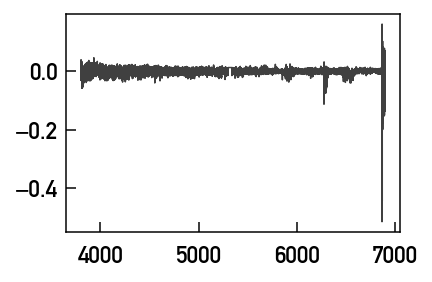

In [40]:
#plt.step(waves, v[0])
plt.step(waves, fluxs[0] - ys_predicted[0], color="k", alpha=0.75)
#plt.step(waves, fluxs[-1] - ys_predicted[-1], color="k", alpha=0.75)
#plt.xlim(xlim)